### Setup

Import Caffe and the usual modules.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.mlab import PCA

%matplotlib inline

#plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import _init_paths
from fast_rcnn.config import cfg, cfg_from_file
from fast_rcnn.test import _get_blobs
from utils.cython_nms import nms
from utils.timer import Timer
import scipy.io as sio
import caffe, os, sys, cv2

### Configure all the constants

Define net path, data path and so on.

In [2]:
DATA_PATH = '/mnt/wb/dataset/LINEMOD4FRCNN'
FRCNN_ROOT_DIR = '/mnt/wb/project/fast-rcnn'

CLASSES = ('__background__',
           'ape', 'benchviseblue', 'bowl', 'cam', 'can', 
           'cat', 'cup', 'driller', 'duck', 'eggbox', 
           'glue', 'holepuncher', 'iron', 'lamp', 'phone')

NETS = {'pose_net_30k': ('wb_CaffeNet',
                     'test_linemod_pose_reg.prototxt',
                     'caffenet_fast_rcnn_pose_reg_iter_30000.caffemodel')}

DATASETS = {'linemod_test': (DATA_PATH + '/data/ImageSets/test.txt',
                  DATA_PATH + '/test.mat')}

CFG_FILE = FRCNN_ROOT_DIR+'/experiments/wb_cfgs/linemod_pose_reg.yml'

GPU_ID = 10

prototxt = os.path.join(FRCNN_ROOT_DIR, 'models', NETS['pose_net_30k'][0],
                            NETS['pose_net_30k'][1])
caffemodel = os.path.join(FRCNN_ROOT_DIR, 'output', 'LINEMOD',
                              NETS['pose_net_30k'][2])

images = DATASETS['linemod_test'][0]
proposals = DATASETS['linemod_test'][1]

### Load net

In [3]:
cfg_from_file(CFG_FILE)

caffe.set_mode_gpu()
caffe.set_device(GPU_ID)
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

### Load data

Load images and proposals

In [23]:
image_names = [line.strip() for line in open(images).readlines()]
image_pathes = ['{0}/{1}/{2}{3}'.format(DATA_PATH, 'data/Images', image_name, '.jpg')\
                for image_name in image_names]
img_num = len(image_names)
image_boxes = [0 for i in range(img_num)]
image_boxes_cls = [0 for i in range(img_num)]

for i in range(img_num):
    filename = os.path.join(DATA_PATH , 'data', 'Annotations', image_names[i] + '.txt')
    # print 'Loading: {}'.format(filename)
    with open(filename) as f:
        data = f.readlines()

    objs = data
    num_objs = len(objs)
    boxes = np.zeros((num_objs, 4), dtype=np.uint16)
    gt_classes = np.zeros((num_objs), dtype=np.int32)

    # Load object bounding boxes into a data frame.
    for ix, obj in enumerate(objs):
        # Make pixel indexes 0-based
        cls_bb = obj.strip().split(' ')
        cls_name = cls_bb[0]
        x1 = float(cls_bb[1])
        y1 = float(cls_bb[2])
        x2 = float(cls_bb[3])
        y2 = float(cls_bb[4])
        cls = CLASSES.index(cls_name)
        boxes[ix, :] = [x1, y1, x2, y2]
        gt_classes[ix] = cls
    image_boxes[i] = boxes
    image_boxes_cls[i] = gt_classes

### Compute features
Compute features of last fully-connected layers

In [38]:
score_list = [ 0 for _ in range(img_num)]
fc6_list = [ 0 for _ in range(img_num)]
fc7_list = [ 0 for _ in range(img_num)]

for i in range(img_num):
    im = cv2.imread(image_pathes[i])
    # change the box format from matlab(1-based index, colomn major) to python format(0-based index, row major)
    boxes = image_boxes[i]
        
    blobs, unused_im_scale_factors = _get_blobs(im, boxes)

    # reshape network inputs
    net.blobs['data'].reshape(*(blobs['data'].shape))
    net.blobs['rois'].reshape(*(blobs['rois'].shape))
    
    feat_blobs_names = ['fc6', 'fc7']
    blobs_out = net.forward(blobs=feat_blobs_names, data=blobs['data'].astype(np.float32, copy=False),
                        rois=blobs['rois'].astype(np.float32, copy=False))
    
    score_list[i] = np.copy(blobs_out['cls_prob'])
    fc6_list[i] = np.copy(blobs_out['fc6'])
    fc7_list[i] = np.copy(blobs_out['fc7'])

### Visualize features
Visualize features of last fully-connected layers

In [74]:
# reduce the feature demension to 3 or 2 using PCA
# reference https://www.clear.rice.edu/comp130/12spring/pca/pca_docs.shtml
# fc6: 4096
# fc7: 4096

# stack the features
scores = np.vstack(score_list)
fc6s = np.vstack(fc6_list)
fc7s = np.vstack(fc7_list)

# calculate classification accuracy
boxes_gt_cls = np.array(image_boxes_cls).flatten()
threshold=0.8
box_ids, boxes_pre_cls = np.where(scores>threshold)

is_correct = boxes_gt_cls[box_ids] == boxes_pre_cls
is_corrent_num = len(np.where(is_correct==True)[0])
accuracy = 100.0*is_corrent_num/len(boxes_gt_cls)
print('Accuracy: {0}%'.format(accuracy))

# PCA on fc features
# because some variances of fc6s columns are 0.0, so here we did not stardardize the data
#  by set standardize=False
# see http://stackoverflow.com/questions/27211263/linalgerror-svd-did-not-converge-in-matplotlib-pca
# Or we remove the columns whose variances are 0.0



Accuracy: 99.8359310911%


In [75]:
fc6s_std = np.std(fc6s, axis=0)
fc6s_std_gz = np.where(fc6s_std>1e-6)
fc6s_selected = fc6s[:,fc6s_std_gz[0]]
fc7s_std = np.std(fc7s, axis=0)
fc7s_std_gz = np.where(fc7s_std>1e-6)
fc7s_selected = fc7s[:,fc7s_std_gz[0]]

fc6s_pca = PCA(fc6s_selected)
fc7s_pca = PCA(fc7s_selected)
fc6s_prj = fc6s_pca.Y
fc7s_prj = fc7s_pca.Y

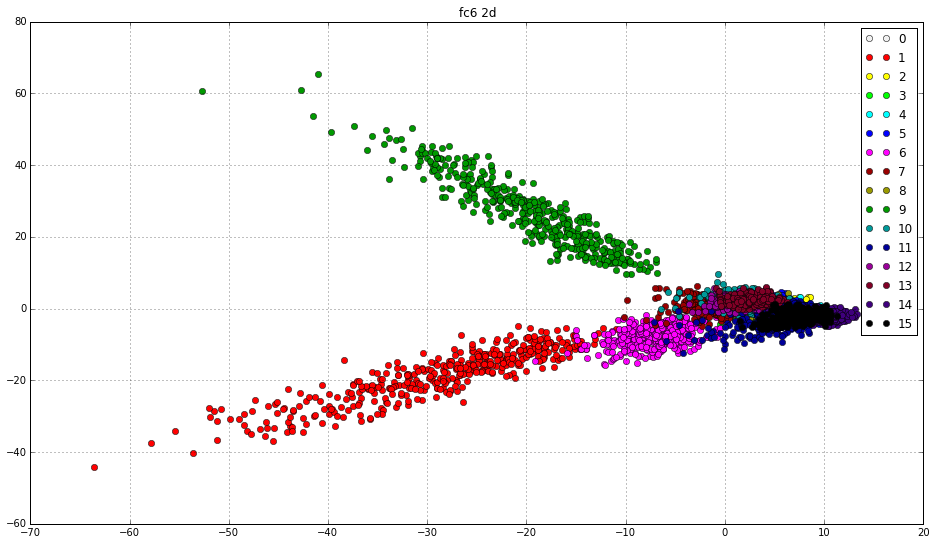

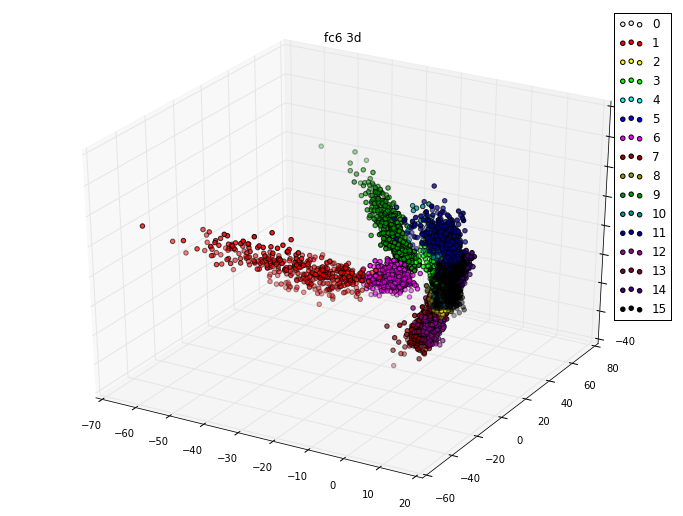

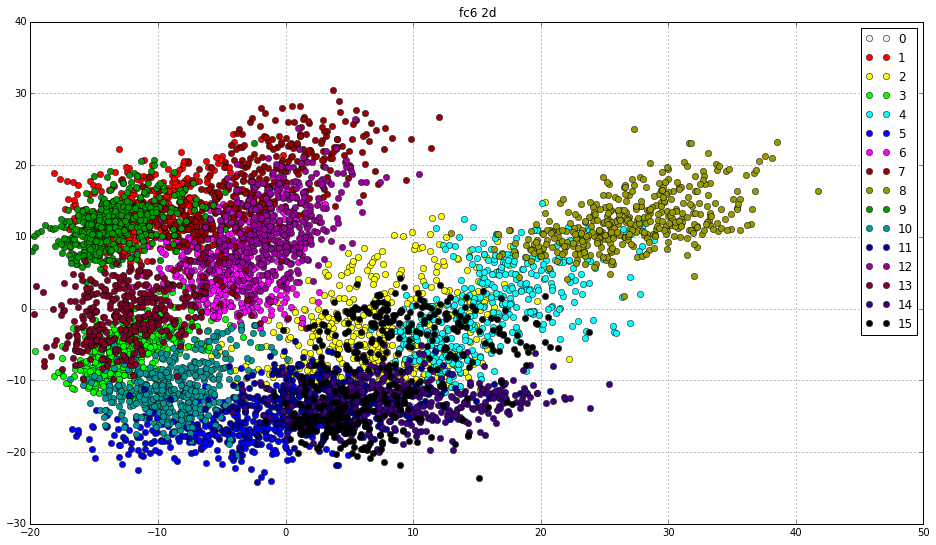

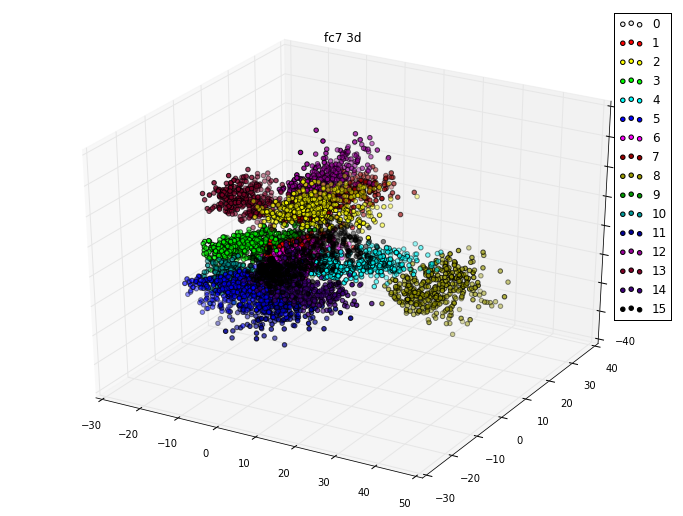

In [78]:
# 2d display
fc6s_2d = plt.figure(figsize=(16,9))
c = ['#f0f0f0','#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
    '#ff00ff', '#990000', '#999900', '#009900', '#009999',
    '#000099', '#990099', '#800026', '#3f007d', '#000000']
for i in range(len(CLASSES)):
    plt.plot(fc6s_prj[boxes_gt_cls==i,0].flatten(), fc6s_prj[boxes_gt_cls==i,1].flatten(), 'o', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])
plt.grid()
plt.title('fc6 2d')
plt.show()

# 3d display
fc6s_3d = plt.figure(figsize=(12,9))
ax_fc6s_3d = fc6s_3d.add_subplot(111, projection='3d')
for i in range(len(CLASSES)):
    ax_fc6s_3d.scatter(fc6s_prj[boxes_gt_cls==i,0].flatten(), fc6s_prj[boxes_gt_cls==i,1].flatten(), \
                       fc6s_prj[boxes_gt_cls==i,2].flatten(), c=c[i], marker='o')
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])
plt.title('fc6 3d')
plt.show()

# 2d display
fc7s_2d = plt.figure(figsize=(16,9))
for i in range(len(CLASSES)):
    plt.plot(fc7s_prj[boxes_gt_cls==i,0].flatten(), fc7s_prj[boxes_gt_cls==i,1].flatten(), 'o', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])
plt.grid()
plt.title('fc6 2d')
plt.show()

# 3d display
fc7s_3d = plt.figure(figsize=(12,9))
ax_fc7s_3d = fc7s_3d.add_subplot(111, projection='3d')
for i in range(len(CLASSES)):
    ax_fc7s_3d.scatter(fc7s_prj[boxes_gt_cls==i,0].flatten(), fc7s_prj[boxes_gt_cls==i,1].flatten(), \
                       fc7s_prj[boxes_gt_cls==i,2].flatten(), c=c[i], marker='o')
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])
plt.title('fc7 3d')
plt.show()